# New Zeland Infection Model

## Model using a grid

* https://github.com/projectmesa/mesa/wiki/Mesa-Packages
* https://github.com/metalcorebear/Mesa-SIR
* https://github.com/projectmesa/mesa/blob/master/examples/virus_on_network/virus_on_network/model.py
* https://github.com/Corvince/mesa-geo
* https://www.youtube.com/watch?v=lcySLoprPMc&t=202s
* https://www.sciencedirect.com/science/article/pii/S1755436517300221
* https://nbviewer.jupyter.org/gist/jlstevens/9c7835e4e21c5d844ded

In [2]:
import time, enum
import numpy as np
import pandas as pd
import pylab as plt
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector

In [5]:
from bokeh.io import show, output_notebook
from bokeh.models import ColumnDataSource, GeoJSONDataSource, ColorBar, HoverTool, Legend, LinearColorMapper, ColorBar
from bokeh.plotting import figure
from bokeh.palettes import brewer
from bokeh.models.glyphs import Line
from bokeh.palettes import Category10, Viridis
output_notebook()
import panel as pn
import panel.widgets as pnw
pn.extension()

Loading BokehJS ...

In [159]:
class State(enum.IntEnum):
    SUSCEPTIBLE = 0
    INFECTED = 1
    REMOVED = 2
    AWAY = 3

## DefaultAgent

In [193]:
class MyAgent(Agent):
    """ An agent in an epidemic model."""
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.age = self.random.normalvariate(20,60)        
        self.state = State.SUSCEPTIBLE  
        self.infection_time = 0

    def move(self):
        """Move the agent"""

        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore=True,
            include_center=False)
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def status(self):
        """Check infection status"""
        
        if self.state == State.INFECTED:     
            drate = self.model.death_rate
            alive = np.random.choice([0,1], p=[drate,1-drate])
            if alive == 0:
                self.model.schedule.remove(self)
                self.state = State.AWAY
                
            t = self.model.schedule.time-self.infection_time
            if t >= self.recovery_time:          
                self.state = State.REMOVED

    def contact(self):
        """Find close contacts and infect"""
        
        cellmates = self.model.grid.get_cell_list_contents([self.pos])       
        if len(cellmates) > 1:
            #other = self.random.choice(cellmates)
            for other in cellmates:
                #print (self.model.schedule.time,self.state,other.state)                
                if self.random.random() > model.ptrans:
                    continue
                if self.state is State.INFECTED and other.state is State.SUSCEPTIBLE:                    
                    other.state = State.INFECTED
                    other.infection_time = self.model.schedule.time
                    other.recovery_time = model.get_recovery_time()
                
    def step(self):
        self.status()
        self.move()
        self.contact()


## VisitorAgent

In [167]:
class VisitorAgent(Agent):
    """ An agent in an epidemic model."""
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.age = self.random.normalvariate(20,25)   
        self.infection_time = 0
        self.stay_time = 10
        self.start_time = self.model.schedule.time
        self.avoid_quarantine = 0.5
        self.is_isolated = False
        
        self.break_quarantine = np.random.choice([0,1], p=[1-self.model.break_quarantine_prob,self.model.break_quarantine_prob])
        if self.break_quarantine == 1:
            self.state = State.INFECTED 
        else: 
            self.state = State.REMOVED 

    def move(self):
        """Move the agent"""

        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore=False,
            include_center=True)
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def status(self):
        """Check infection status"""
           
        t = self.model.schedule.time-self.infection_time
        if t >= self.start_time + self.stay_time:    
            self.model.grid.move_agent(self, (0,0))
#             self.model.grid.place_agent(self, (-1, -1))
            self.model.schedule.remove(self) 
            self.state = State.AWAY
            

    def contact(self):
        """Find close contacts and infect"""
        
        cellmates = self.model.grid.get_cell_list_contents([self.pos])       
        if len(cellmates) > 1:
            #other = self.random.choice(cellmates)
            for other in cellmates:
                #print (self.model.schedule.time,self.state,other.state)                
                if self.random.random() > model.ptrans:
                    continue
                if self.state is State.INFECTED and other.state is State.SUSCEPTIBLE:                    
                    other.state = State.INFECTED
                    other.infection_time = self.model.schedule.time
                    other.recovery_time = model.get_recovery_time()
                
    def step(self):
        self.status()
        self.move()
        self.contact()


## Model class

In [191]:
class GridInfectionModel(Model):
    """A model for infection spread."""
    
    def __init__(self, N=10, width=10, height=10, ptrans=0.5, 
                 progression_period=3, progression_sd=2, death_rate=0.01, recovery_days=21,
                 recovery_sd=7, visitor_stay_len=21, visitor_stay_len_sd=0, visiting_freq=0.5,
                 visitors_group_size=10, break_quarantine_prob=0.2 ):
        
        self.num_agents = N
        self.initial_outbreak_size = 0
        self.recovery_days = recovery_days
        self.recovery_sd = recovery_sd
        self.visitor_stay_len = visitor_stay_len
        self.visitor_stay_len_sd = visitor_stay_len_sd
        self.visiting_freq = visiting_freq
        self.visitors_group_size = visitors_group_size
        self.break_quarantine_prob = break_quarantine_prob
        
        self.ptrans = ptrans
        self.death_rate = death_rate
        self.grid = MultiGrid(width, height, True)
        # https://github.com/projectmesa/mesa/blob/master/mesa/time.py
        self.schedule = RandomActivation(self)
        self.running = True
        self.dead_agents = []
        
        self.add_recovered()
        
        # Create agents
        for i in range(self.num_agents):
            a = MyAgent(i, self)
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))
            
        self.datacollector = DataCollector(
            #model_reporters={"Gini": compute_gini}, 
            agent_reporters={"State": "state"})

    def get_recovery_time(self):
        return int(self.random.normalvariate(self.recovery_days,self.recovery_sd))
    
    def get_visitor_return_time(self):
        return int(self.random.normalvariate(self.visitor_stay_len,self.visitor_stay_len_sd))
    
    def add_visitor(self):
        uid = self.random.randrange(1000, 3000)
        a = VisitorAgent(uid, self)
        self.schedule.add(a)

        x = self.random.randrange(self.grid.width)
        y = self.random.randrange(self.grid.height)
        self.grid.place_agent(a, (x, y))

        a.stay_time = self.get_visitor_return_time()    
            
    def add_recovered(self):
        uid = self.random.randrange(3000, 4000)
        a = MyAgent(uid, self)
        self.schedule.add(a)

        x = self.random.randrange(self.grid.width)
        y = self.random.randrange(self.grid.height)
        self.grid.place_agent(a, (x, y))

        a.state = State.REMOVED
    
    def add_to_dead_agents(self, agent):
        self.dead_agents.append(agent)
    
    def step(self):
        toss = np.random.choice([0,1], p=[1-self.visiting_freq,self.visiting_freq])
        if toss == 1: 
            for i in range(self.visitors_group_size):
                self.add_visitor()

        self.datacollector.collect(self)
        self.schedule.step()



## Bokeh plots (do not edit)

In [163]:
def get_column_data(model):
    #pivot the model dataframe to get states count at each step
    agent_state = model.datacollector.get_agent_vars_dataframe()
    X = pd.pivot_table(agent_state.reset_index(),index='Step',columns='State',aggfunc=np.size,fill_value=0)    
    labels = ['Susceptible','Infected','Recovered']
    X.columns = labels[:len(X.columns)]
    return X
    
def plot_states(model,ax):    
    steps = model.schedule.steps
    X = get_column_data(model)
    X.plot(ax=ax,lw=3,alpha=0.8)

In [186]:
def grid_values(model):
    """Get grid states"""
    
    agent_counts = np.zeros((model.grid.width, model.grid.height))
    for cell in model.grid.coord_iter():
        agents, x, y = cell
        c=None
        for a in agents:
            c = a.state
        agent_counts[x,y] = c
    df=pd.DataFrame(agent_counts)  
    return df

# x=grid_values(model)
# print(x)

In [182]:
def plot_cells_bokeh(model):
    """Plot model grid values as a grid"""
    
    agent_counts = np.zeros((model.grid.width, model.grid.height))
    w=model.grid.width
    df=grid_values(model) 
    df = pd.DataFrame(df.stack(), columns=['value']).reset_index()    
    columns = ['value']
    x = [(i, "@%s" %i) for i in columns]    
    hover = HoverTool(
        tooltips=x, point_policy='follow_mouse')
    colors = Category10[3]
    mapper = LinearColorMapper(palette= ['blue', 'orange', 'green', 'black'], low=0, high=3) #, low=df.value.min(), high=df.value.max())
    p = figure(plot_width=500,plot_height=500, tools=[hover], x_range=(-1,w), y_range=(-1,w))
    p.rect(x="level_0", y="level_1", width=1, height=1,
       source=df,
       fill_color={'field':'value', 'transform': mapper},
       line_color='black')
    p.background_fill_color = "black"
    p.grid.grid_line_color = None    
    p.axis.axis_line_color = None
    p.toolbar.logo = None
    return p

# p=plot_cells_bokeh(model)
# pn.pane.Bokeh(p)

In [185]:
def plot_states_bokeh(model,title=''):
    """Plot cases per country"""
        
    X = get_column_data(model)
    X = X.reset_index()
    source = ColumnDataSource(X)
    i=0
    colors = Category10[3]
    items=[]
    p = figure(plot_width=300,plot_height=200,tools=[],title=title,x_range=(0,100))        
    for c in X.columns[1:]:
        line = Line(x='Step',y=c, line_color=colors[i],line_width=3,line_alpha=.8,name=c)
        glyph = p.add_glyph(source, line)
        i+=1
        items.append((c,[glyph]))

    p.xaxis.axis_label = 'Step'
    p.add_layout(Legend(location='center_right',   
                items=items))
    p.background_fill_color = "#e1e1ea"
    p.background_fill_alpha = 0.5
    p.legend.label_text_font_size = "10pt"
    p.title.text_font_size = "15pt"
    p.toolbar.logo = None
    p.sizing_mode = 'scale_height'    
    return p

# p = plot_states_bokeh(model)
# pn.pane.Bokeh(p)

## Final plot and model

In [174]:
plot_pane = pn.pane.Bokeh()
grid_pane = pn.pane.Bokeh()
pn.Row(plot_pane,grid_pane,sizing_mode='stretch_width')

Row(sizing_mode='stretch_width')
    [0] Bokeh(None)
    [1] Bokeh(None)

# >>> Run model with updates <<<

* pop - population
* width, height - map size
* ptrans - transmission probability when agents meet
* death_rate - death rate, when agent is infected
* recovery_days, recovery_sd - days agent need to recover (Infected -> Removed/Recoverd status) and standard dev
* visitor_stay_len, visitor_stay_len_sd - days visitor agen stay on the map and standard dev
* visiting_freq - probability of adding new visitor in each step
* visitors_group_size - number of visitors added at once
* break_quarantine_prob - probability of breaking the quaranitne by visitor and going on the adventure inside the country

In [201]:
steps=100
pop=500
speed = 0.1

st=time.time()
# EDIT PARAMS HERE:
model = GridInfectionModel(pop, width=40, height=40, 
                           ptrans=0.1, death_rate=0.01, 
                           recovery_days=21, recovery_sd=7, 
                           visitor_stay_len=21, visitor_stay_len_sd=10,
                           visiting_freq=0.5, visitors_group_size=10, 
                           break_quarantine_prob=0.1
                          )

for i in range(steps):
    model.step()    
    p1=plot_states_bokeh(model,title='step=%s' %i)
    plot_pane.object = p1
    p2=plot_cells_bokeh(model)
    grid_pane.object = p2
    time.sleep(speed)
print (time.time()-st)

20.178363800048828


## Show only params

In [196]:
st=time.time()
for i in range(steps):
    model.step()
print (time.time()-st)
agent_state = model.datacollector.get_agent_vars_dataframe()
print (get_column_data(model))

1.122755765914917
      Susceptible  Infected  Recovered
Step                                  
0             400         5          6
1             400         7         13
2             400        11         18
3             400        16         23
4             397        23         29
...           ...       ...        ...
167           139       116        309
168           138       111        301
169           138       106        299
170           137       102        296
171           136       107        297

[172 rows x 3 columns]


## Show only final map

In [197]:
p=plot_cells_bokeh(model)
pn.pane.Bokeh(p)

Bokeh(Figure)

## Show only chart

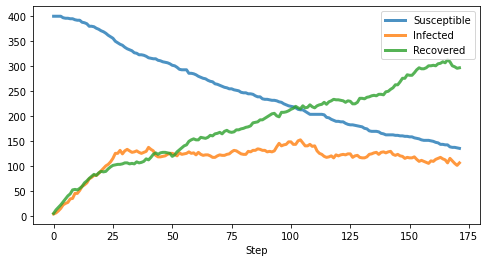

In [198]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SIR.png',dpi=300)